In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ODE solver
from scipy.integrate import solve_ivp

# See below
import importlib

# This contains all the functions needed for simulation
import functions

# This helps reload the 'functions' module. By default, this is not done.
importlib.reload(functions) 

<module 'functions' from 'C:\\Users\\bai_f\\Documents\\research\\TakedaInternship\\simulation\\functions.py'>

In [7]:
# Parameters and initial conditions
# Set basal parameter values
functions.set_basal_parameter_values()
# Turn off binding/unbinding, transportation, monomer production in ISF
# ... and antibody entrance
functions.set_basal_parameter_values_Michaels(basal_concentration=1e-9)
# Turn on monomer production in ISF
functions.parameters['k_ISF_AbM_syn'] = 7
# Set clearance rate, only estimated
functions.parameters['k_ISF_AbM_clear'] = 0.1
functions.parameters['k_ISF_AbF_clear'] = 0.001
# antibody production rate, guess
functions.parameters['k_ISF_mAb_syn'] = 0.1
# Assume that antibodies are cleared at the same rate as fibrils
functions.parameters['k_ISF_mAb_clear'] = 1e-3
# Assume that antibody-monomer complexes are cleared at the same rate as fibrils
functions.parameters['k_ISF_AbF_mAb_clear'] = 1e-3

# Estimated binding and dissociation rate
functions.parameters['k_ISF_AbF_mAb_bind'] = 1e-3 * functions.parameters['t0']
functions.parameters['k_ISF_AbF_mAb_diss'] = 1e-3 * functions.parameters['t0']

# Set all species to be zero, return y0 as the initial condition for ODE solver
y0 = functions.set_zero_initial_conditions()

In [8]:
base_value = functions.parameters['k_ISF_mAb_syn']

x_fold_min = 0
x_fold_max = 10
x_fold_mid = int((x_fold_min+x_fold_max)/2)

xmin = x_fold_min * base_value
xmax = x_fold_max * base_value
xmid = (xmin + xmax)/2

par_range = np.linspace(xmin, xmax, 101)



# Time constants
t_start = 0
t_end = 200000

t_span = [t_start, t_end]
t_eval = np.linspace(t_start, t_end, 100+1)

# Initial conditions
y0 = functions.set_zero_initial_conditions()

ISF_AbM_infty_list = []
ISF_AbF_infty_list = []
ISF_AbON_infty_list = []
ISF_mAb_infty_list = []
ISF_AbM_mAb_infty_list = []


for functions.parameters['k_ISF_mAb_syn'] in par_range:
    sol = solve_ivp(functions.RHS, t_span, y0, 
                    method='LSODA', t_eval = t_eval, rtol=1e-3, max_step=1e2)
    ISF_AbM_infty_list.append(sol.y[functions.indices_species['ISF_AbM'], -1])
    ISF_AbF_infty_list.append(sol.y[functions.indices_species['ISF_AbF'], -1] 
                             + sol.y[functions.indices_species['ISF_AbF1'], -1]
                             + sol.y[functions.indices_species['ISF_AbF2'], -1])                             
    ISF_AbON_infty_list.append(sol.y[functions.indices_species['ISF_AbON'], -1])
    ISF_mAb_infty_list.append(sol.y[functions.indices_species['ISF_mAb'], -1])
    ISF_AbM_mAb_infty_list.append(sol.y[functions.indices_species['ISF_AbM_mAb'], -1])
    

functions.parameters['k_ISF_mAb_syn'] = base_value

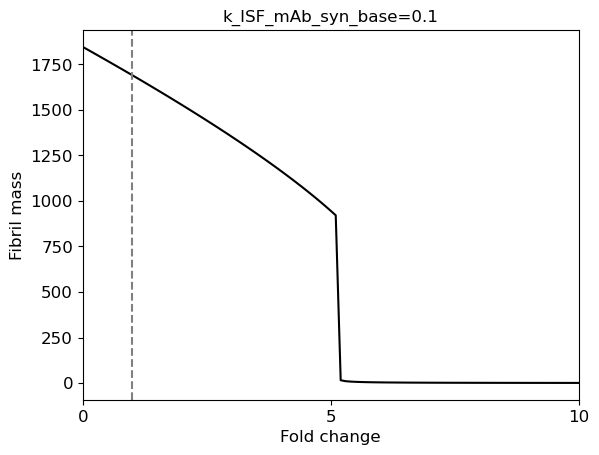

In [9]:
# Visualization of fibrils
fig = plt.figure()
ax = fig.add_subplot(111)
fontsize = 12

ax.plot(par_range, ISF_AbF_infty_list, color='black')
ax.axvline(x=base_value, color='grey', linestyle='--')

ax.set_title(f'k_ISF_mAb_syn_base={base_value}')

ax.set_xlabel('Fold change', fontsize=fontsize)
ax.set_ylabel('Fibril mass', fontsize=fontsize)

ax.set_xlim((xmin, xmax))
ax.set_xticks((xmin, xmid, xmax))
ax.set_xticklabels((x_fold_min, x_fold_mid, x_fold_max))

# Change tick label sizes
tick_label_size = fontsize
ax.tick_params(axis='both', which='major', labelsize=tick_label_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_label_size)



In [10]:
# Save figure
filename = "./figs/ISF_AntibodyEffect_FibrilSurfaceBinding.jpg"
fig.savefig(filename, dpi=600, bbox_inches="tight")